# Imports

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")
plt.rcdefaults()

# Defining the Directories

In [2]:
sequence = "h25_short"
DATA_DIR = '../../data/extracted_images/' + sequence
RESULT_DIR = '../../data/results/' + sequence

# Getting Informations and Reading the Files

## Getting Frame Information

In [3]:
info_dict = {
    "first_frame": 1,
    "last_frame": 2,
    "contact_frame": 3,
    "leave_frame": 4,
    "angle": 5,
    "passthrough": 6,
}

In [4]:
def get_info(file):
    information = {}
    with open(file, "r") as f:
        texts = f.readlines()
    for key, value in info_dict.items():
        line = texts[value]
        info = line.split(":")[1].strip()
        information[key] = info
    return information

information = get_info(f"{DATA_DIR}.txt")

In [5]:
first_frame = DATA_DIR + "/" +information["first_frame"]
last_frame = DATA_DIR + "/" +information["last_frame"]
contact_frame = DATA_DIR + "/" +information["contact_frame"]
angle = information["angle"]
leave_frame = DATA_DIR + "/" +information["leave_frame"]
passthrough = information["passthrough"]

In [6]:
first_frame, last_frame

('../../data/extracted_images/h25_short/005',
 '../../data/extracted_images/h25_short/030')

## Converting the Frame ID to Integer

In [7]:
reg = re.compile(r"\d{3}")
first_frame_num = int(reg.findall(first_frame)[0])
contact_frame_num = int(reg.findall(contact_frame)[0])
leave_frame_num = int(reg.findall(leave_frame)[0])
first_frame_num, contact_frame_num, leave_frame_num

(5, 21, 25)

## Reading the DF

In [8]:
df_name = sequence+"_raw.csv"
df = pd.read_csv(RESULT_DIR + '/'+df_name)
df_c = df[df["x"].notna()]

# Fitting Curves

## The Curves to be Fitted

We'll assume that downward is the positive direction. In this way, the gravitational acceleration is positive. In x direction, no force is acting and hence the equation of motion is simply:
$$
x(t) = x_0 + v_{x0}t
$$
Here $x_0$ is the initial x position, $v_{x0}$ is the initial y velocity.

Now, in y direction, the equation of motion is:
$$
y(t) = y_0 + v_{y0}t + \frac{1}{2}gt^2
$$
Here, $y_0$ is the initial y position, $v_{y0}$ is the initial y velocity, and $g$ is the acceleration due to gravity.

We'll optimize these two equations to get the initial velocity and the initial position for x and y direction.

We can also phrase the same problem by eliminating $t$ from the equation of motions. This way, we'll get $y$ as a function of $x$. Eliminating $t$ from the equation of motion, we get:
$$
y = y_0 + \frac{v_y}{v_x}(x - x_0) + \frac{1}{2}g\frac{(x - x_0)^2}{v_x^2}
$$


Here, we have rewritten $v_{x0}$ as $v_x$ and $v_{y0}$ as $v_y$. 
<!-- Defining $\frac{v_y}{v_x}$ as $m$, which is nothing but $\tan(\theta)$ where $\theta$ is the angle between the y and x velocity, we get:
$$
y = y_0 + m(x - x_0) + \frac{1}{2}g\frac{(x - x_0)^2}{v_x^2}
$$ -->

This is a parabola with the parameters $y_0$, $m$, $g$ and $v_x$ and $v_y$. We can use `scipy` to get these parameters.

In [9]:
def the_parabola(x, x0, y0, vy, vx, g):
    second_term = (vy/vx)*(x-x0)
    third_term = 0.5*g*((x-x0)/vx)**2
    return y0 + second_term + third_term
the_parabola_vector = np.vectorize(the_parabola)

However, it turned out that using the parabola does not give a reasonable result. So, we'll be using the parametric equations.

In [10]:
def parametric_x(t, x0, vx0):
    return x0 + vx0*t
parametric_x_vector = np.vectorize(parametric_x)

def parametric_y(t, y0, vy0, g):
    return y0 + vy0*t+0.5*g*t**2
parametric_y_vector = np.vectorize(parametric_y)

## Region III

### Data For Region III

In [11]:
region_3 = df_c[df_c["Region"] == "III"]

In [12]:
X = region_3["x"].values
Y = region_3["y"].values
t = region_3["time"].values
offset = t[0]
tbar = t-offset

In [13]:
tbar

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 14, 15])

### Fitting the Curves

In [37]:
popt, pcov = curve_fit(the_parabola, X, Y, maxfev=10000)
popty, pcovy = curve_fit(parametric_y, tbar, Y)
poptx, pcovx = curve_fit(parametric_x, tbar, X)

In [15]:
popt

array([ 4.12457327e+02,  6.33652625e+04,  1.98078644e+02, -5.36389312e-01,
        3.12009393e-01])

As you can see, the parameters calculated by the fitting method is ridiculus, even though it fits the parabola well (See the figure below).

In [16]:
poptx, popty

(array([7.48252740e+02, 3.42737235e-02]),
 array([495.02674836,  12.13788906,  -1.79768362]))

These values are reasonable.

In [17]:
g = popty[2]
g

-1.7976836169907577

### Analyzing the Results

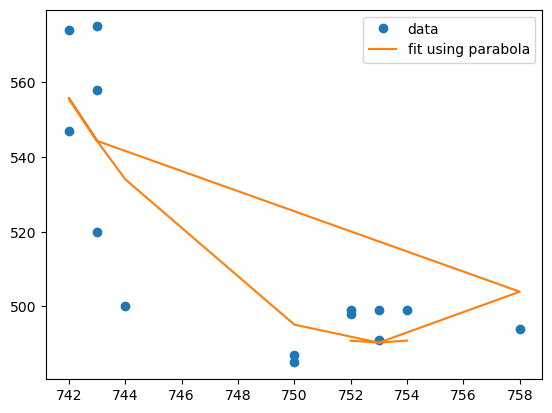

In [18]:
plt.plot(X,Y, 'o', label="data")
plt.plot(X, the_parabola_vector(X, *popt),label="fit using parabola")
plt.legend();

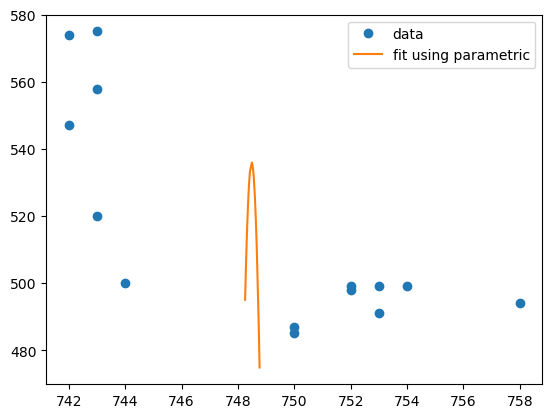

In [38]:
plt.plot(X,Y, 'o', label="data")
plt.plot(parametric_x_vector(tbar, *poptx), parametric_y_vector(tbar, *popty), label="fit using parametric")
plt.legend();

We can see that using the parametric equations, we can fit the curve accurately.

### Getting Speeds

Next, we'll see how the calculated velocities are? The eqaution for the speeds are:
$$
v_x(t) = v_{x0}\\
v_y(t) = v_{y0} + gt
$$

In [20]:
vy = popty[1]+popty[2]*(tbar)
vx = np.ones(len(tbar))*poptx[1]
v = np.sqrt(vy**2+vx**2)

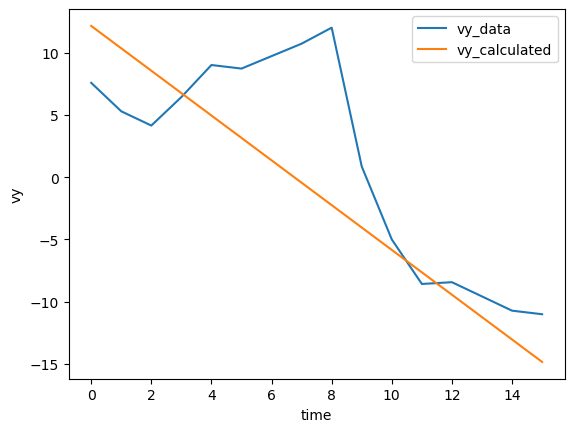

In [21]:
plt.plot(tbar, region_3["vy"].values, label="vy_data")
plt.plot(tbar, vy, label="vy_calculated")
plt.legend()
plt.xlabel("time")
plt.ylabel("vy");

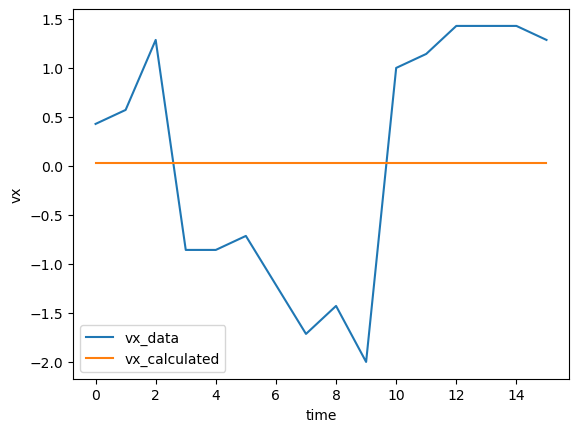

In [22]:
plt.plot(tbar, region_3["vx"].values, label="vx_data")
plt.plot(tbar, vx, label="vx_calculated")
plt.legend()
plt.xlabel("time")
plt.ylabel("vx");

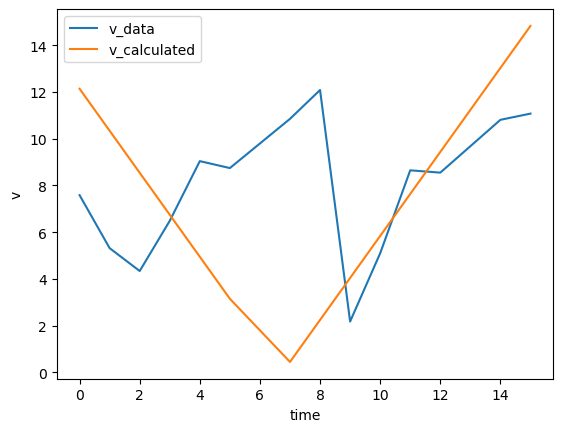

In [23]:
plt.plot(tbar, region_3["v"].values, label="v_data")
plt.plot(tbar, v, label="v_calculated")
plt.legend()
plt.xlabel("time")
plt.ylabel("v");

They are reasonable.

### Getting Angles

Next, let's calculate the angle between the x and y velocity.

In [24]:
angles= np.arctan(vy/vx)*180/np.pi

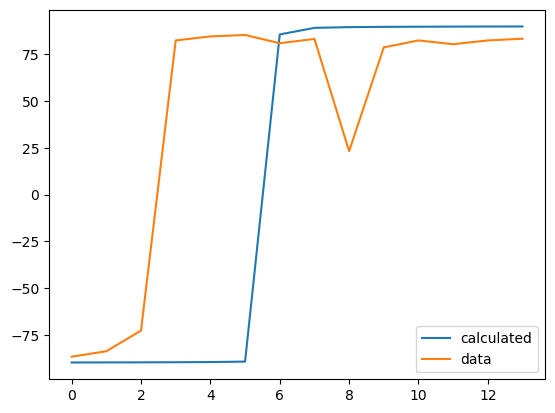

In [25]:
plt.plot(-angles, label = "calculated")
plt.plot(region_3["angle"].values, label = "data")
plt.legend();

Again, reasonable.

## Getting the Additional Information

In [26]:
new_info_df = pd.DataFrame({"vx": vx, "vy": vy, "v":v, "angle": angles, "time":t})
new_info_df.columns = ["vx_using_curve", "vy_using_curve", "v_using_curve", "angle_using_curve", "time"]

In [27]:
new_info_df

,vx_using_curve,vy_using_curve,v_using_curve,angle_using_curve,time
0,0.034274,12.137889,12.137937,89.838214,24
1,0.034274,10.340205,10.340262,89.810088,25
2,0.034274,8.542522,8.542591,89.770123,26
3,0.034274,6.744838,6.744925,89.708855,27
4,0.034274,4.947155,4.947273,89.603063,28
5,0.034274,3.149471,3.149657,89.376510,29
6,0.034274,-0.445896,0.447212,-85.604614,31
7,0.034274,-2.243580,2.243842,-89.124797,32
8,0.034274,-4.041263,4.041409,-89.514089,33
9,0.034274,-5.838947,5.839048,-89.663686,34


In [28]:
df_final = pd.merge(df_c, new_info_df, on="time", how="left")
df_final.tail().T

,26,27,28,29,30
id,../../data/extracted_images/h25_short/034.jpg,../../data/extracted_images/h25_short/035.jpg,../../data/extracted_images/h25_short/036.jpg,../../data/extracted_images/h25_short/038.jpg,../../data/extracted_images/h25_short/039.jpg
x,750.0,750.0,753.0,752.0,752.0
y,485.0,487.0,499.0,499.0,498.0
r1,14.0,15.0,74.0,74.0,74.0
r2,89.0,86.0,39.0,40.0,40.0
theta,7.448451,7.448451,99.694656,99.694656,100.267614
vx,1.0,1.142857,1.428571,1.428571,1.285714
vy,-5.0,-8.571429,-8.428571,-10.714286,-11.0
v,5.09902,8.647283,8.54878,10.809104,11.074884
angle,78.690068,82.405357,80.380272,82.405357,83.33334


## Adding the Additional Information

In [29]:
x_speed = vx[0]
y_speed = vy[0]
speed = v[0]
angle = angles[0]
x_speed, y_speed, speed, angle

(0.034273723476552, 12.137889057338352, 12.137937446550591, 89.83821449718204)

In [30]:
pattern = "***"
information = f"""USING CURVE FIT AT LEAVE FRAME
### ANGLE: {np.round(angle, 2)}
### VELOCITY: {np.round(speed, 2)}
### X VELOCITY: {np.round(x_speed, 2)}
### Y VELOCITY: {np.round(y_speed, 2)}
### g: {np.round(g, 4)}
{pattern*20}
"""
print(information)

USING CURVE FIT AT LEAVE FRAME
### ANGLE: 89.84
### VELOCITY: 12.14
### X VELOCITY: 0.03
### Y VELOCITY: 12.14
### g: -1.7977
************************************************************



First, create a new string containing just the previous text file. Else we'll duplicate the text file.

In [31]:
with open(RESULT_DIR +"/info.txt", "r+") as f:
    texts = f.readlines()
if len(texts)>44:
    text = "".join(texts[:-6])
else:
    text = "".join(texts)
print(text[:125])
all_text = text+information

### h25_short.tif
### First Frame ID: 005
### Last Frame ID: 030
### Contact Frame ID: 021
### Leave Frame ID: 023
### Angle:


In [32]:
len(texts)

43

In [33]:
with open(RESULT_DIR +"/info.txt", "w") as f:
    f.writelines(all_text)

### Save the DataFrame

In [34]:
df_final.to_csv(RESULT_DIR + f"/{sequence}_final.csv", index=False)